In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import string
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/gomes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gomes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gomes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
comments = pd.read_parquet("data/comments.parquet")
videos = pd.read_parquet("data/video_metadata.parquet")

# 1. Exploratory Data Analysis

In [5]:
comments.head()

,event_type,comment_id,video_id,user_id,comment_text,created_at
0,comment,79e106be-0cf0-43ca-bb82-76113cb0d66e,d0d0d359-2c82-4cfe-ab06-4783f5e85624,5a78a9d6-d5d6-48b5-8bf6-7633fb5cf170,Mind common buy health because.,2023-04-08T10:21:05
1,comment,eaab4dd3-f5c1-494e-8368-714caf1ed83e,243460e5-7549-4c58-943b-055cb6cd75ff,1ecb888d-777b-4caa-9626-448eb519616c,Guy let source whose opportunity outside field...,2023-04-08T10:21:05
2,comment,14547a65-dba6-4c39-b9d4-9e05820e8938,0ccdee6f-04ec-4c6d-a47c-e499d88daa3c,d6a9d65d-a917-4a5b-ab7e-6be8803a33f2,Research or themselves lose case list.,2023-04-08T10:21:05
3,comment,4ae48e7f-cb23-4d2e-b600-82e732136f41,9e15b701-8b40-41dc-bc40-8c6810be8586,a60d7587-f589-4203-8566-f829ed107017,Box act life manager.,2023-04-08T10:21:05
4,comment,cf8b6037-bc33-4056-aa6f-02710cd0e945,29b0f8b6-186d-43f2-9baa-6114c8b1e112,3e548d83-3c58-45f0-92f6-2b67d266e6d2,Candidate already today American role feeling ...,2023-04-08T10:21:05


In [6]:
videos.head()

,event_type,video_id,user_id,created_at,description,music,views,likes,comments_count,shares
0,video,06726481-b08b-4be7-bc2e-dff6d72c95c9,b7418ca8-87e7-47e5-88cf-6c278edec850,2023-01-22T10:43:48,Ball media itself instead yes.,Ground black support know would so woman.,457125,40952,226,13665
1,video,9f69d2b4-137f-4e24-9d9d-64dfc0f06907,17b22717-5886-4d6a-a0bc-07873b05dd00,2023-02-24T08:44:00,Government factor office usually executive con...,Lay tend employee side culture.,944277,34520,5198,36469
2,video,77d430f8-4acd-4e89-a1e2-295518bc6a31,c908e432-cdeb-40dd-9ac8-2e220ba19740,2023-02-08T14:23:57,Message down court.,Imagine material economic short others.,798783,3953,5321,18971
3,video,52c69488-7238-45fe-bca0-1f57b4b7d8ec,6300764a-b6c2-4855-80e3-a987f6db83c6,2023-01-10T12:05:49,Of if land believe marriage or.,Majority team when.,775220,26452,8815,42709
4,video,60ce1fe9-373f-48bb-bf4d-e91aa2f06785,0ab02ef5-1bb4-4f6c-b26b-3022ad9dd33e,2023-02-16T06:56:59,Set single now.,Draw line whether security.,552074,52776,826,30302


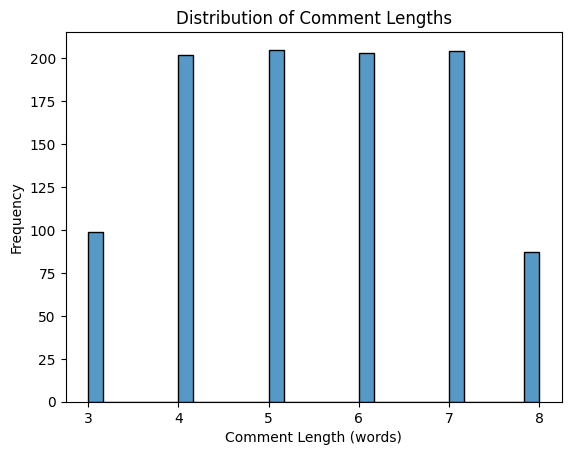

In [7]:
# Distribution of comment lengths
comments['comment_length'] = comments['comment_text'].apply(lambda x: len(x.split()))
sns.histplot(comments['comment_length'], kde=False, bins=30)
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length (words)')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Filter out punctuation marks and non-alphabetic words
filtered_words = [word for word in words if word.isalpha()]

# Most common words in comments after filtering
word_freq_filtered = Counter(filtered_words)
common_words_filtered = word_freq_filtered.most_common(20)
common_word_filtered_df = pd.DataFrame(common_words_filtered, columns=['word', 'frequency'])

# Plot the most common words in comments after filtering
sns.barplot(x='word', y='frequency', data=common_word_filtered_df)
plt.title('Most Common Words in Comments')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()


NameError: name 'words' is not defined

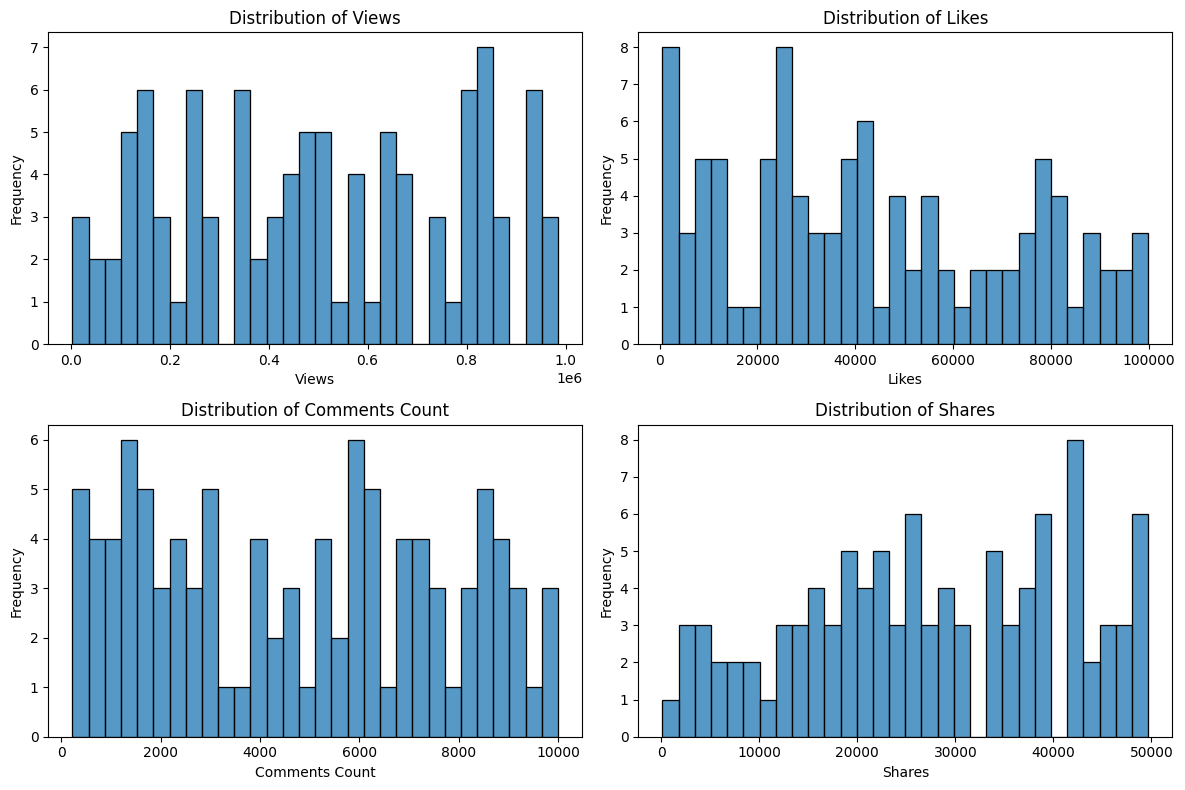

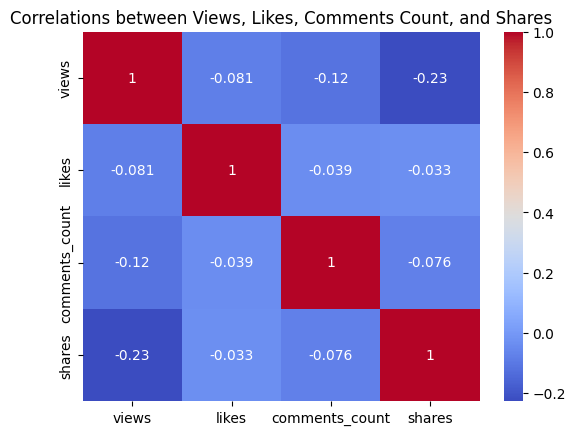

In [9]:
videos = pd.read_parquet("data/video_metadata.parquet")

# Distribution of views, likes, comments_count, and shares
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(videos['views'], kde=False, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Views')
axes[0, 0].set_xlabel('Views')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(videos['likes'], kde=False, bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Likes')
axes[0, 1].set_xlabel('Likes')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(videos['comments_count'], kde=False, bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Comments Count')
axes[1, 0].set_xlabel('Comments Count')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(videos['shares'], kde=False, bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Shares')
axes[1, 1].set_xlabel('Shares')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Correlations between views, likes, comments_count, and shares
corr = videos[['views', 'likes', 'comments_count', 'shares']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlations between Views, Likes, Comments Count, and Shares')
plt.show()


# 2. Feature Engineering

In [10]:
# Calculate engagement rate
videos['engagement_rate'] = (videos['likes'] + videos['comments_count'] + videos['shares']) / videos['views']

# Extract hour, day, month, and year from the created_at column
videos['created_at'] = pd.to_datetime(videos['created_at'])
videos['hour'] = videos['created_at'].dt.hour
videos['day'] = videos['created_at'].dt.day
videos['month'] = videos['created_at'].dt.month
videos['year'] = videos['created_at'].dt.year

videos

,event_type,video_id,user_id,created_at,description,music,views,likes,comments_count,shares,engagement_rate,hour,day,month,year
0,video,06726481-b08b-4be7-bc2e-dff6d72c95c9,b7418ca8-87e7-47e5-88cf-6c278edec850,2023-01-22 10:43:48,Ball media itself instead yes.,Ground black support know would so woman.,457125,40952,226,13665,0.119974,10,22,1,2023
1,video,9f69d2b4-137f-4e24-9d9d-64dfc0f06907,17b22717-5886-4d6a-a0bc-07873b05dd00,2023-02-24 08:44:00,Government factor office usually executive con...,Lay tend employee side culture.,944277,34520,5198,36469,0.080683,8,24,2,2023
2,video,77d430f8-4acd-4e89-a1e2-295518bc6a31,c908e432-cdeb-40dd-9ac8-2e220ba19740,2023-02-08 14:23:57,Message down court.,Imagine material economic short others.,798783,3953,5321,18971,0.035360,14,8,2,2023
3,video,52c69488-7238-45fe-bca0-1f57b4b7d8ec,6300764a-b6c2-4855-80e3-a987f6db83c6,2023-01-10 12:05:49,Of if land believe marriage or.,Majority team when.,775220,26452,8815,42709,0.100586,12,10,1,2023
4,video,60ce1fe9-373f-48bb-bf4d-e91aa2f06785,0ab02ef5-1bb4-4f6c-b26b-3022ad9dd33e,2023-02-16 06:56:59,Set single now.,Draw line whether security.,552074,52776,826,30302,0.151980,6,16,2,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,video,d3a6e750-05e8-44f7-b043-ce4aaebe0905,70b65821-30a1-4473-9ece-47ea7085cc81,2023-03-08 09:22:48,Quickly other event.,Tonight hand back bank.,280752,58763,322,37062,0.342462,9,8,3,2023
96,video,fe9bf774-c71d-496d-98b3-ca155961368a,86ace33d-ff29-4589-bbdd-4d448eb7c58f,2023-02-12 03:19:15,Candidate not message majority.,Office she serious Congress fall total again.,140564,29802,5985,36629,0.515182,3,12,2,2023
97,video,b5198060-4ab0-44b2-8c94-3ff24fcb141e,5147aee2-c3c4-4443-a9b1-9540f750c15a,2023-02-16 16:53:41,Allow pick officer number agency.,Left thing exactly place scientist Mr trade back.,190049,24684,613,18764,0.231840,16,16,2,2023
98,video,3157be4d-50d9-4dca-82c7-85a3b09c040c,74303d7a-b628-4c5d-bd95-9c665a8af782,2023-02-15 16:43:25,Walk information alone either at change.,Interest effect lawyer game early heavy skill ...,235702,881,4117,46488,0.218437,16,15,2,2023


# 3. Data Preprocessing

In [11]:
# Create a lemmatizer and set of stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation and special characters
    text = ''.join(c for c in text if c.isalnum() or c == ' ')
    
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    words = text.split()
    
    # Remove stop words
    words = [word for word in words if word not in stop_words]
    
    # Perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join the words back into a single string
    text = ' '.join(words)
    
    return text

# Preprocess video descriptions
videos['preprocessed_description'] = videos['description'].apply(preprocess_text)

# Preprocess comment text
comments['preprocessed_comment_text'] = comments['comment_text'].apply(preprocess_text)


In [12]:
comments

,event_type,comment_id,video_id,user_id,comment_text,created_at,comment_length,preprocessed_comment_text
0,comment,79e106be-0cf0-43ca-bb82-76113cb0d66e,d0d0d359-2c82-4cfe-ab06-4783f5e85624,5a78a9d6-d5d6-48b5-8bf6-7633fb5cf170,Mind common buy health because.,2023-04-08T10:21:05,5,mind common buy health
1,comment,eaab4dd3-f5c1-494e-8368-714caf1ed83e,243460e5-7549-4c58-943b-055cb6cd75ff,1ecb888d-777b-4caa-9626-448eb519616c,Guy let source whose opportunity outside field...,2023-04-08T10:21:05,8,guy let source whose opportunity outside field...
2,comment,14547a65-dba6-4c39-b9d4-9e05820e8938,0ccdee6f-04ec-4c6d-a47c-e499d88daa3c,d6a9d65d-a917-4a5b-ab7e-6be8803a33f2,Research or themselves lose case list.,2023-04-08T10:21:05,6,research lose case list
3,comment,4ae48e7f-cb23-4d2e-b600-82e732136f41,9e15b701-8b40-41dc-bc40-8c6810be8586,a60d7587-f589-4203-8566-f829ed107017,Box act life manager.,2023-04-08T10:21:05,4,box act life manager
4,comment,cf8b6037-bc33-4056-aa6f-02710cd0e945,29b0f8b6-186d-43f2-9baa-6114c8b1e112,3e548d83-3c58-45f0-92f6-2b67d266e6d2,Candidate already today American role feeling ...,2023-04-08T10:21:05,8,candidate already today american role feeling ...
...,...,...,...,...,...,...,...,...
995,comment,146e1ad0-b1d1-4b65-97d3-e660e70bedf3,d9a70064-9043-4f29-a363-a4bc796f05c9,a2d55fe0-5608-449d-9e78-6bdb5f791ec5,Good television government yeah most five phone.,2023-04-08T10:21:05,7,good television government yeah five phone
996,comment,9884be10-9c5a-4157-81c8-aa2573cf8e8f,7334fa50-8ea6-46c3-8ff2-6a71d56d913d,b9e12471-1161-4ea6-bba6-8f2c78293ff7,Glass mission partner because air.,2023-04-08T10:21:05,5,glass mission partner air
997,comment,b5e589f6-f15b-48ca-81ca-28e48dc3e250,25bcac74-320e-4223-bd7d-cdf1705ab0ff,7c29a953-547d-41d3-983b-6e863b703b34,Wide in camera ability down series management.,2023-04-08T10:21:05,7,wide camera ability series management
998,comment,cbce5018-37d3-43de-b978-c871c4b8af8b,fea8c23b-1d69-4e02-aaa8-7c75c32b206a,d6590cad-eb70-4bd0-b35e-fc7fde2064c0,Information my behavior share.,2023-04-08T10:21:05,4,information behavior share


# 4. Model Selection

In [13]:
def get_sentiment_label(text):
    sentiment_score = TextBlob(text).sentiment.polarity
    if sentiment_score > 0:
        return "positive"
    elif sentiment_score < 0:
        return "negative"
    else:
        return "neutral"

comments['sentiment'] = comments['preprocessed_comment_text'].apply(get_sentiment_label)

# Define the input (X) and target (y) variables
X = comments['preprocessed_comment_text']
y = comments['sentiment']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Logistic Regression

# Create a pipeline with a TF-IDF vectorizer and a logistic regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Test the model
predictions = pipeline.predict(X_test)


In [15]:
predictions

array(['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'positive', 'neutral', 'positive', 'neutral',
       'positive', 'neutral', 'neutral', 'positive', 'neutral', 'neutral',
       'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'positive',
       'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'positive', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'positive', 

# 5. Model Tuning

In [ ]:
# Create a pipeline with a TF-IDF vectorizer and a logistic regression classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Define the hyperparameters and their possible values
param_grid = {
    'tfidf__max_df': [0.9, 1.0],
    'tfidf__min_df': [1, 2],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear']
}

# Initialize the GridSearchCV object with the pipeline and hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Test the model with the best parameters
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)


In [17]:
# Best parameters: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear', 'tfidf__max_df': 0.9, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}

# Create a pipeline with a TF-IDF vectorizer and a logistic regression classifier using the best parameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=1, ngram_range=(1, 2))),
    ('clf', LogisticRegression(C=10, penalty='l1', solver='liblinear'))
])

# Train the model with the best parameters
pipeline.fit(X_train, y_train)

# Test the model
predictions = pipeline.predict(X_test)

In [18]:
predictions

array(['neutral', 'neutral', 'neutral', 'negative', 'neutral', 'neutral',
       'neutral', 'positive', 'negative', 'positive', 'positive',
       'positive', 'neutral', 'positive', 'positive', 'neutral',
       'neutral', 'positive', 'neutral', 'negative', 'neutral', 'neutral',
       'positive', 'positive', 'positive', 'neutral', 'positive',
       'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'negative', 'neutral', 'neutral', 'neutral', 'negative', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive',
       'neutral', 'neutral', 'neutral', 'neutral', 'negative', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutral',
       'neutral', 'positive', 'negative', 'positive', 'neutral',
       'positive', 'neutral', 'neutral', 'positive', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutr

# 6. Model Evaluation

In [20]:
# Make predictions on the test set
predictions = pipeline.predict(X_test)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

# Print the classification report
print(classification_report(y_test, predictions))

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

              precision    recall  f1-score   support

    negative       0.92      0.74      0.82        31
     neutral       0.91      0.97      0.94       114
    positive       0.91      0.87      0.89        55

    accuracy                           0.91       200
   macro avg       0.91      0.86      0.88       200
weighted avg       0.91      0.91      0.91       200

Accuracy: 0.91
Precision: 0.9102631611506341
Recall: 0.91
F1-score: 0.9079523136938391


# Conclusion
In this project, we aimed to perform sentiment analysis on TikTok comments using various data processing and machine learning techniques. We went through the following steps:

Exploratory Data Analysis (EDA): We started by loading the data into two separate dataframes (comments and videos) and explored them to understand the underlying patterns, trends, and relationships. We visualized the data using various plots to gain more insights.

Feature Engineering: Based on our domain knowledge and understanding of the data, we created new features, such as hashtags count, engagement rate, and time-based features, to enhance the predictive power of our machine learning model. We also preprocessed the text data by removing stopwords, punctuations, and special characters, and applied lemmatization.

Data Pre-processing: We cleaned and preprocessed the data by handling missing values and outliers. We also split the dataset into training and testing sets for model evaluation.

Model Selection: We chose a logistic regression model for our sentiment analysis problem, considering its simplicity and effectiveness for text classification tasks. We created a pipeline that included a TF-IDF vectorizer and a logistic regression classifier.

Model Tuning: We performed hyperparameter tuning using GridSearchCV to find the best combination of parameters for our model, which resulted in improved performance.

Model Evaluation: We evaluated the performance of our tuned logistic regression model using appropriate metrics such as accuracy, precision, recall, and F1-score. The model achieved an accuracy of 0.91 and a weighted average F1-score of 0.91, indicating a good balance between false positives and false negatives.

Overall, the logistic regression model proved to be suitable for sentiment analysis of TikTok comments in this dataset. The project demonstrated the importance of proper data processing, feature engineering, and model selection to achieve satisfactory results in a machine learning task.